In [3]:
# external packages
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
import torch.nn.functional as F
import pytorch_lightning as pl
from argparse import Namespace
import sys
import yaml

# own code
sys.path.append('../')
from preprocessing import get_array_from_nifti, roi_crop_multiple_images

In [64]:
interobserver_dir = Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\interobserver_labels_n=3")
labelers = ["Fleur", "Floor", "Roel"]
patients = ['DRAUMC0585_LGE_seq0_PSIR', 'DRAUMC0634_LGE_seq0_PSIR', 'DRAUMC1017_LGE_seq0_PSIR_singleshot']
data = {}
for patient in patients:
    data[patient] = {}
    data[patient]['img'] = interobserver_dir.joinpath(f"{patient}.nrrd")
    for labeler in labelers:
        data[patient][labeler] = {}
        data[patient][labeler]['myo'] = interobserver_dir.joinpath(f"{patient}_{labeler}-myo.nrrd")
        data[patient][labeler]['fib'] = interobserver_dir.joinpath(f"{patient}_{labeler}-aankleuring.nrrd")
        
def one_vs_all_dice(segmentations, dim='3D'):
    assert dim in ['3D', '2D']
    if dim == '3D':
        axis = None
    else:
        axis = (-1, -2)
    results = []
    all_dices = []
    for i in range(len(segmentations)):
        seg = segmentations[i]
        other_segs = segmentations[:i] + segmentations[i+1:]
        dices = []
        for other_seg in other_segs:
            dice = ((seg > 0) * (other_seg > 0)).sum(axis=axis) * 2 / (other_seg.sum(axis=axis) + seg.sum(axis=axis))
            all_dices.append(dice)
            dices.append(dice)
        results.append(np.array(dices).mean(axis=0))
    
    assert len(segmentations) == 3, "To lazy to properly code this"
    if dim == '3D':
        all_dices = list(set(all_dices))
        print(np.array(all_dices))
    avg_dice = np.array(all_dices).mean()
    std = np.array(all_dices).std()
    return results, avg_dice, std

def vs_ground_truth_dice(segmentations, dim='3D'):
    """ground truth is assumed to be the first segmentation in segmentations"""
    assert dim in ['3D', '2D']
    ground_truth = segmentations[0]
    other_segmentations = segmentations[0:]
    if dim == '3D':
        axis = None
    else:
        axis = (-1, -2)
    results = []
    for i in range(1, len(other_segmentations)):
        seg = other_segmentations[i]
        dice = ((ground_truth > 0) * (seg > 0)).sum(axis=axis) * 2 / (seg.sum(axis=axis) + ground_truth.sum(axis=axis))
        results.append(np.array(dice))
    
    return results
        
        

In [12]:
def plot_data_v1(data, max_slices=10, subplot_size=4, labelers=['Fleur', 'Floor', 'Roel'], annotate_dice=True):
    for patient in data:
        image = get_array_from_nifti(data[patient]['img'])[0]
        myo_gts, fib_gts = [], []
        for labeler in labelers:
            myo_gts.append(get_array_from_nifti(data[patient][labeler]['myo']))
            fib_gts.append(get_array_from_nifti(data[patient][labeler]['fib']))
            
        image = roi_crop_multiple_images(myo_gts[0], [image], fixed_size=100)[0]
        fib_gts = roi_crop_multiple_images(myo_gts[0], fib_gts, fixed_size=100)[:-2]
        myo_gts = roi_crop_multiple_images(myo_gts[0], myo_gts, fixed_size=100)[:-2]
        
        
        labelers_abc = ['Labeler A', ' Labeler B', 'Labeler C']
            
        fib_dices_3D, avg, std = one_vs_all_dice(fib_gts, dim='3D')
        print(f"{patient} Fibrosis mean dice:{avg}, std: {std}")
        fib_dices_2D, avg, std = one_vs_all_dice(fib_gts, dim='2D')
        myo_dices_3D, avg, std = one_vs_all_dice(myo_gts, dim='3D')
        print(f"{patient} Myocardium mean dice:{avg}, std: {std}")
        myo_dices_2D, avg, std = one_vs_all_dice(myo_gts, dim='2D')
    
        # create fig & axis labels
        n_rows = len(image)
        n_cols = 1+len(labelers)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(subplot_size*n_cols,subplot_size*n_rows))

        # add a big axis, hide frame
        fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
        #plt.xlabel("Model supervision/input")
        plt.ylabel("Patient slices")

        plt.subplots_adjust(wspace=0, hspace=0)
        for i in range(n_rows):
            axs[i, 0].set_ylabel(f"{i}")
        axs[0, 0].set_title('Image slice')
        for j, name in enumerate(labelers_abc):
            axs[0, j+1].set_title(f"{name}")
        for ax in axs.flat:
            ax.set_xticks([], [])
            ax.set_yticks([], [])    

        for i in range(n_rows):
            axs[i, 0].imshow(image[i], cmap="gray")

            if annotate_dice == True:
                axs[i, 0].text(30, 30, f"Fibrosis Dice 2D\nFibrosis Dice 3D\nMyocardium Dice 2D\nMyocardium Dice 3D", fontsize='large', color='white', weight='bold')

            for j, (myo_gt, fib_gt) in enumerate(zip(myo_gts, fib_gts)):
                axs[i, j+1].imshow(image[i], cmap="gray")
                masked_myo = np.ma.masked_where(myo_gt[i] <= 0.0, myo_gt[i] > 0.0)
                axs[i, j+1].imshow(masked_myo, cmap="GnBu", alpha=0.8, vmin=0.0, vmax=1)
                masked_fib = np.ma.masked_where(fib_gt[i] < 0.5, fib_gt[i] >= 0.5)
                axs[i, j+1].imshow(masked_fib, cmap="bwr", alpha=0.8, vmin=0.0, vmax=1)
                if annotate_dice == True:
                    axs[i, j+1].text(70, 30, f"{fib_dices_2D[j][i]:.3f}\n{fib_dices_3D[j]:.3f}\n{myo_dices_2D[j][i]:.3f}\n{myo_dices_3D[j]:.3f}", fontsize='large', color='white', weight='bold')
    return

[0.5698324  0.66714594 0.64239272]
DRAUMC0585_LGE_seq0_PSIR Fibrosis mean dice:0.6264570194079857, std: 0.04129520498437214
[0.76807301 0.78409091 0.86636278]
DRAUMC0585_LGE_seq0_PSIR Myocardium mean dice:0.8061755676449435, std: 0.043058245556820675


C:\Users\rcklein\AppData\Local\Temp\ipykernel_18300\2900513056.py:26: RuntimeWarning: invalid value encountered in true_divide
  dice = ((seg > 0) * (other_seg > 0)).sum(axis=axis) * 2 / (other_seg.sum(axis=axis) + seg.sum(axis=axis))


[0.69053302 0.75656109 0.8099658 ]
DRAUMC0634_LGE_seq0_PSIR Fibrosis mean dice:0.7523533015677505, std: 0.04884892922335773
[0.81710497 0.85246164 0.87101   ]
DRAUMC0634_LGE_seq0_PSIR Myocardium mean dice:0.8468588674881582, std: 0.02236040048608639
[0.5720524  0.60406447 0.50169033]
DRAUMC1017_LGE_seq0_PSIR_singleshot Fibrosis mean dice:0.5592690679898902, std: 0.042760389239211154
[0.76786325 0.76316099 0.74923171]
DRAUMC1017_LGE_seq0_PSIR_singleshot Myocardium mean dice:0.7600853188898089, std: 0.007911103545573018


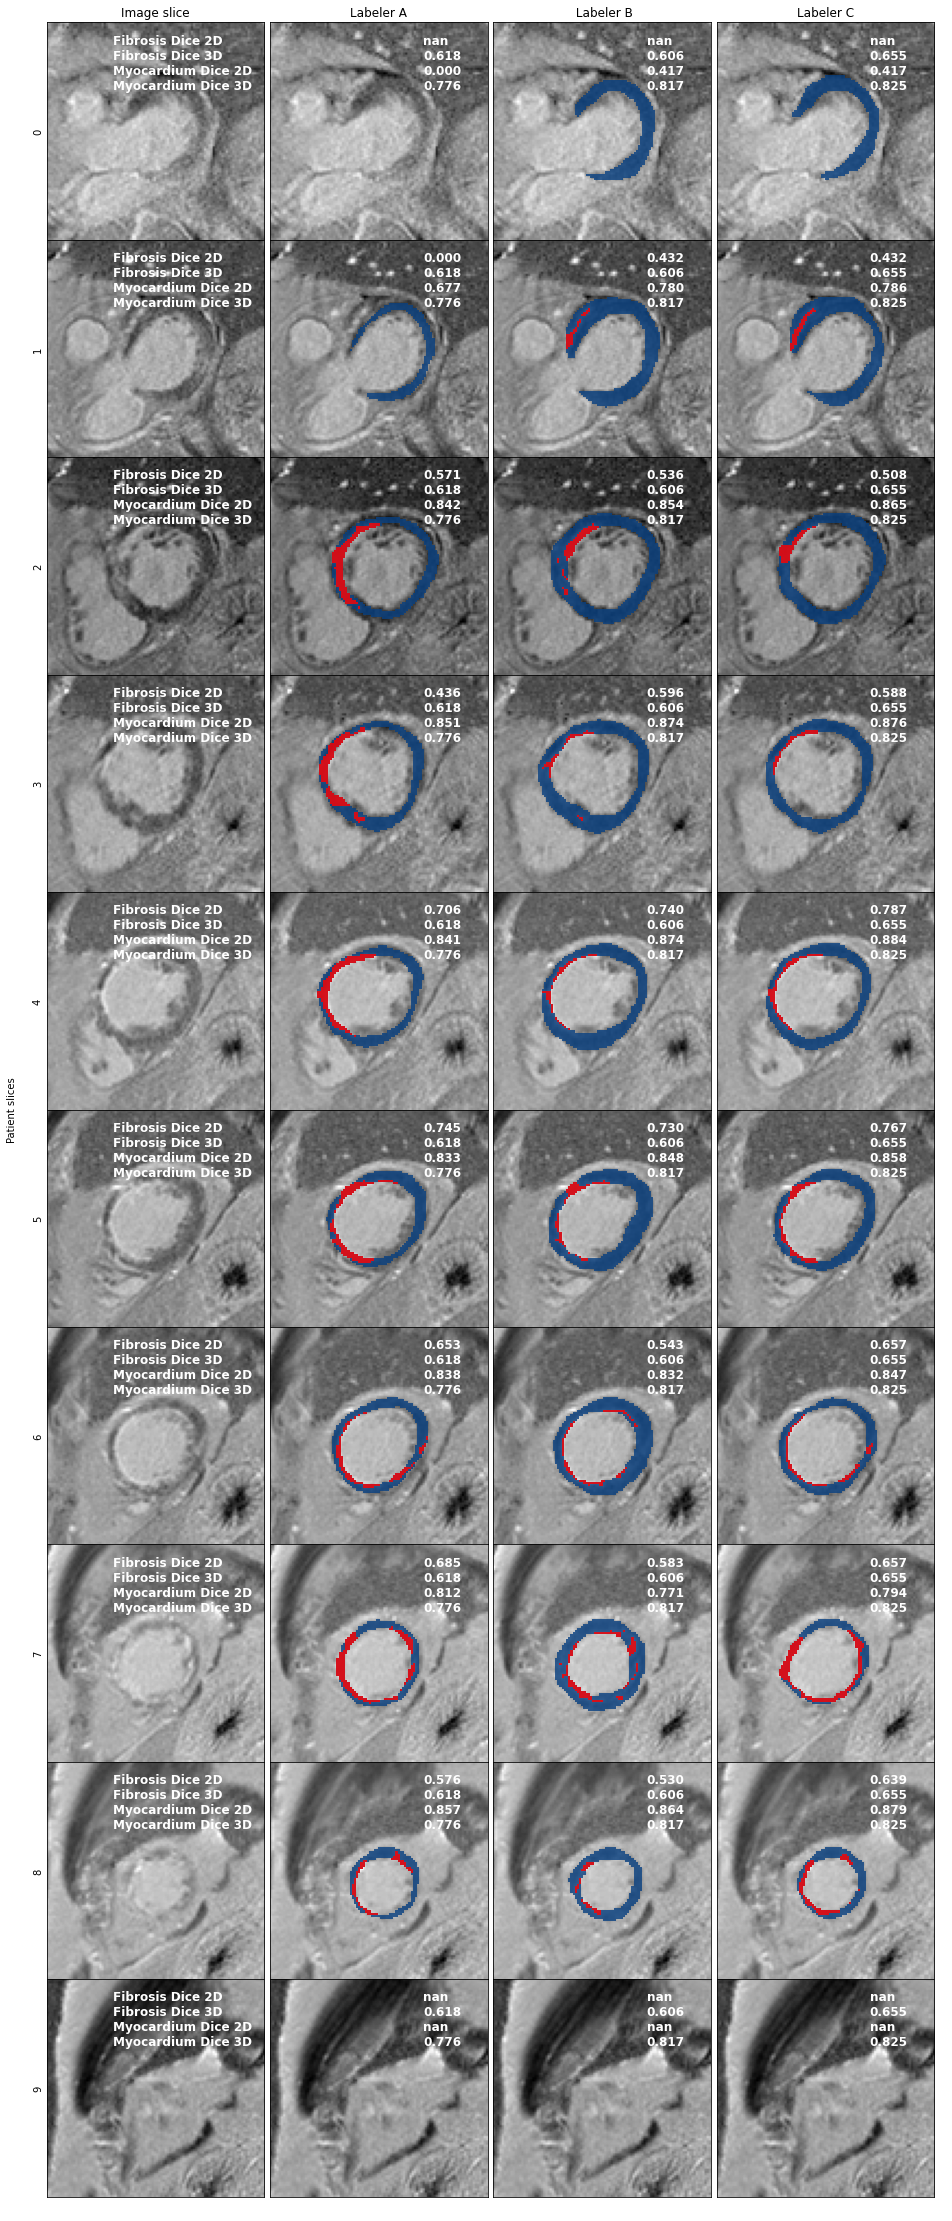

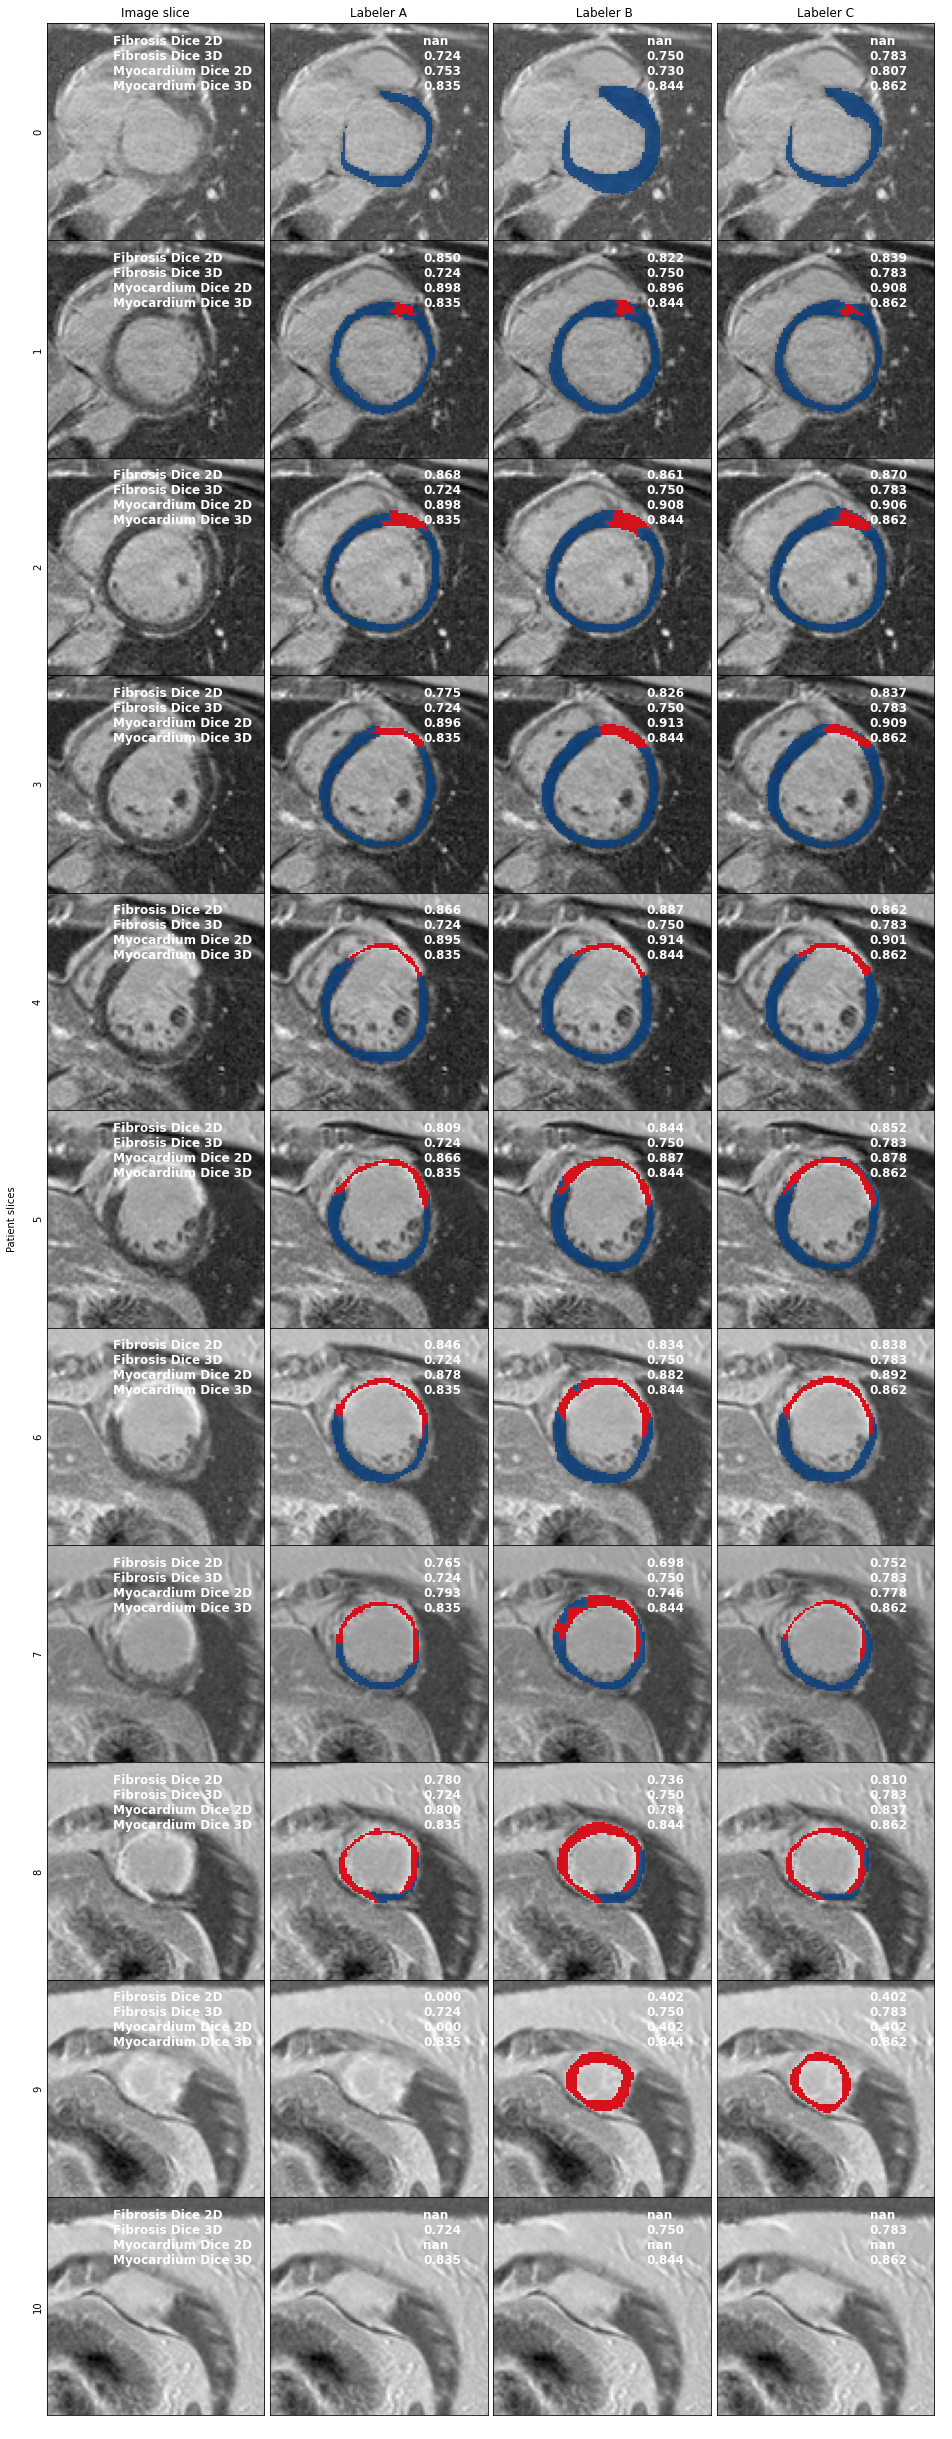

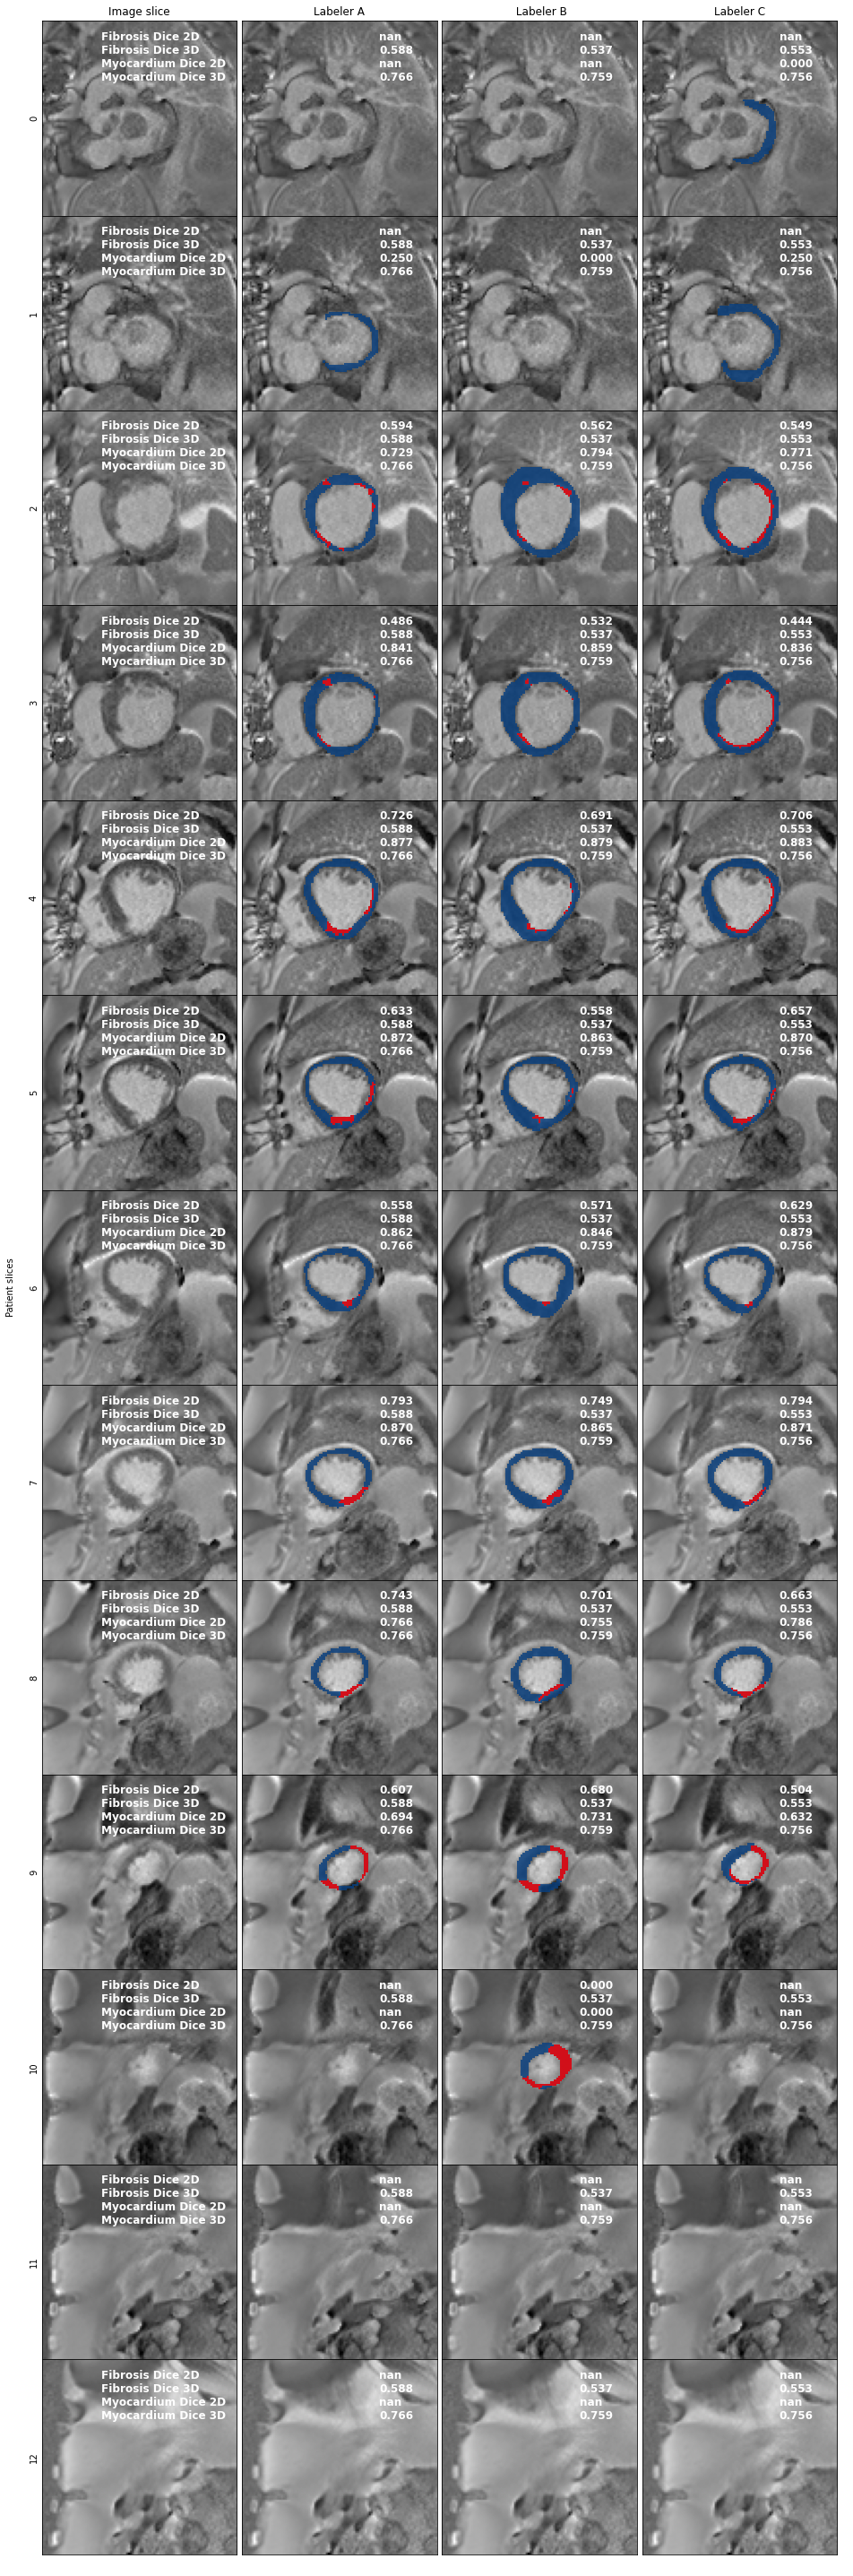

In [13]:
plot_data_v1(data)

In [83]:
def plot_data_v2(data, subplot_size=3, labelers=['Fleur', 'Floor', 'Roel'], annotate_dice=True):
    gt_threshold = 0.5
    for patient in data:
        image = get_array_from_nifti(data[patient]['img'])[0]
        myo_gts, fib_gts = [], []
        for labeler in labelers:
            myo_gts.append(get_array_from_nifti(data[patient][labeler]['myo']))
            fib_gts.append(get_array_from_nifti(data[patient][labeler]['fib']))
            
        image = roi_crop_multiple_images(myo_gts[0], [image], fixed_size=100)[0]
        fib_gts = roi_crop_multiple_images(myo_gts[0], fib_gts, fixed_size=100)[:-2]
        myo_gts = roi_crop_multiple_images(myo_gts[0], myo_gts, fixed_size=100)[:-2]
        
        
        labelers_abc = ['Ground truth', ' Student A', 'Student B']
        fib_dices_3D = vs_ground_truth_dice(fib_gts, dim='3D')
        fib_dices_2D = vs_ground_truth_dice(fib_gts, dim='2D')
        myo_dices_3D = vs_ground_truth_dice(myo_gts, dim='3D')
        myo_dices_2D = vs_ground_truth_dice(myo_gts, dim='2D')
    
        # create fig & axis labels
        n_rows = len(image)
        n_cols = 1+len(labelers)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(subplot_size*n_cols,subplot_size*n_rows))

        # add a big axis, hide frame
        fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
        #plt.xlabel("Model supervision/input")
        plt.ylabel("Patient slices")

        plt.subplots_adjust(wspace=0, hspace=0)
        for i in range(n_rows):
            axs[i, 0].set_ylabel(f"{i}")
        axs[0, 0].set_title('Image slice')
        for j, name in enumerate(labelers_abc):
            axs[0, j+1].set_title(f"{name}")
        for ax in axs.flat:
            ax.set_xticks([], [])
            ax.set_yticks([], [])
            
        

        for i in range(n_rows):
            axs[i, 0].imshow(image[i], cmap="gray")
            
            masked_gt_fib = np.ma.masked_where(fib_gts[0][i] <= gt_threshold, fib_gts[0][i] > gt_threshold)
            masked_gt_myo = np.ma.masked_where(myo_gts[0][i] <= gt_threshold, myo_gts[0][i] > gt_threshold)
            axs[i, 1].imshow(image[i], cmap="gray")
            axs[i, 1].imshow(masked_gt_myo, cmap="GnBu", alpha=0.8, vmin=0.0, vmax=1)
            axs[i, 1].imshow(masked_gt_fib, cmap="bwr", alpha=0.8, vmin=0.0, vmax=1)
            if annotate_dice == True:
                #axs[i, 1].text(30, 30, f"Fibrosis Dice 2D\nFibrosis Dice 3D\nMyocardium Dice 2D\nMyocardium Dice 3D", fontsize='x-large', color='white', weight='bold')
                axs[i, 1].text(10, 20, f"Fibrosis Dice 2D\nFibrosis Dice 3D", fontsize='x-large', color='white', weight='bold')

            for j, (myo_gt, fib_gt) in enumerate(zip(myo_gts[1:], fib_gts[1:])):
                axs[i, j+2].imshow(image[i], cmap="gray")
                masked_myo = np.ma.masked_where(myo_gt[i] <= 0.0, myo_gt[i] > 0.0)
                axs[i, j+2].imshow(masked_myo, cmap="GnBu", alpha=0.8, vmin=0.0, vmax=1)
                masked_fib = np.ma.masked_where(fib_gt[i] < 0.5, fib_gt[i] >= 0.5)
                axs[i, j+2].imshow(masked_fib, cmap="bwr", alpha=0.8, vmin=0.0, vmax=1)
                if annotate_dice == True:
                    #axs[i, j+2].text(60, 30, f"{fib_dices_2D[j][i]:.3f}\n{fib_dices_3D[j]:.3f}\n{myo_dices_2D[j][i]:.3f}\n{myo_dices_3D[j]:.3f}", fontsize='x-large', color='white', weight='bold')
                    axs[i, j+2].text(60, 20, f"{fib_dices_2D[j][i]:.3f}\n{fib_dices_3D[j]:.3f}", fontsize='x-large', color='white', weight='bold')
    return

C:\Users\rcklein\AppData\Local\Temp\ipykernel_18300\1439737382.py:51: RuntimeWarning: invalid value encountered in true_divide
  dice = ((ground_truth > 0) * (seg > 0)).sum(axis=axis) * 2 / (seg.sum(axis=axis) + ground_truth.sum(axis=axis))


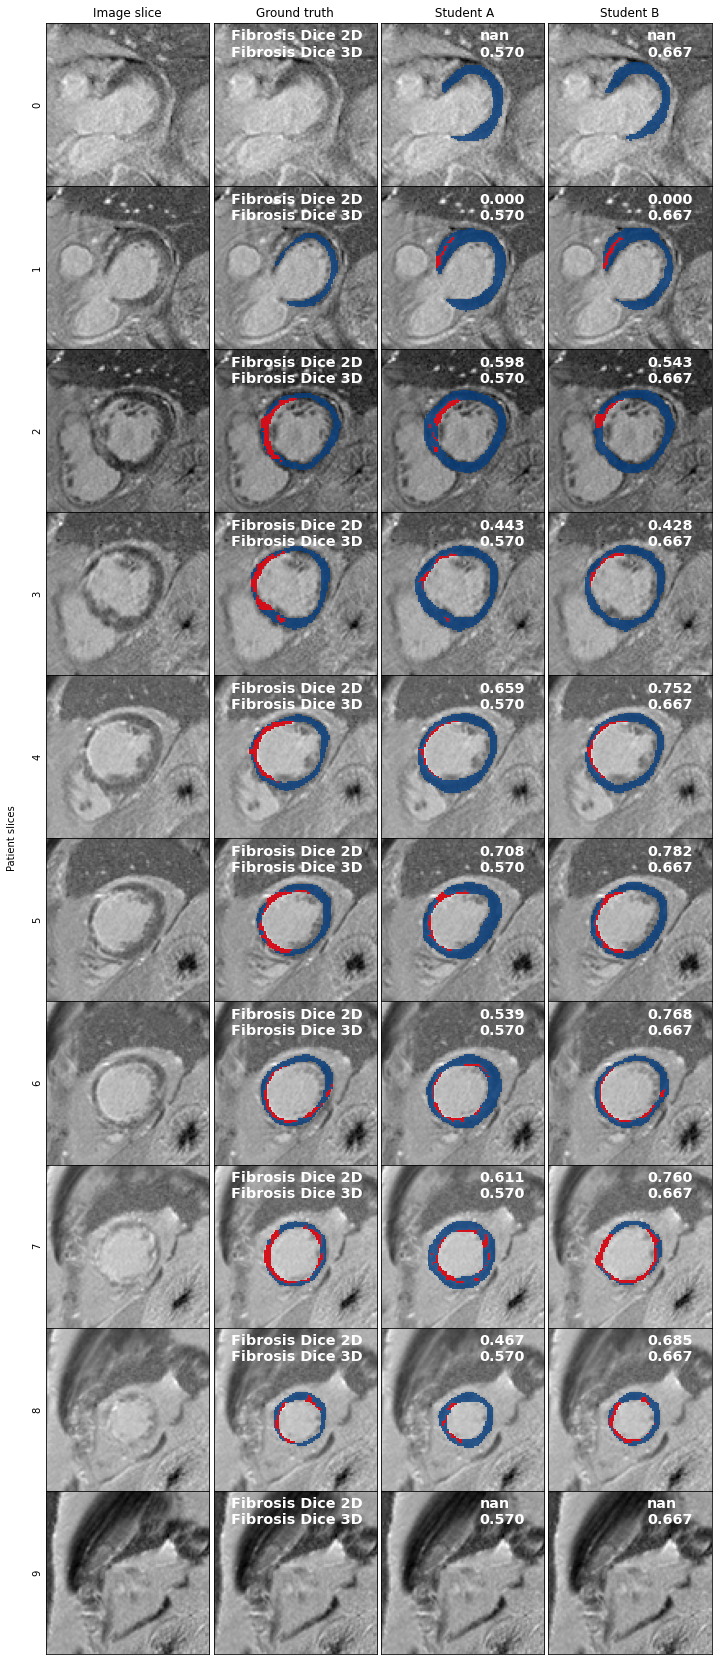

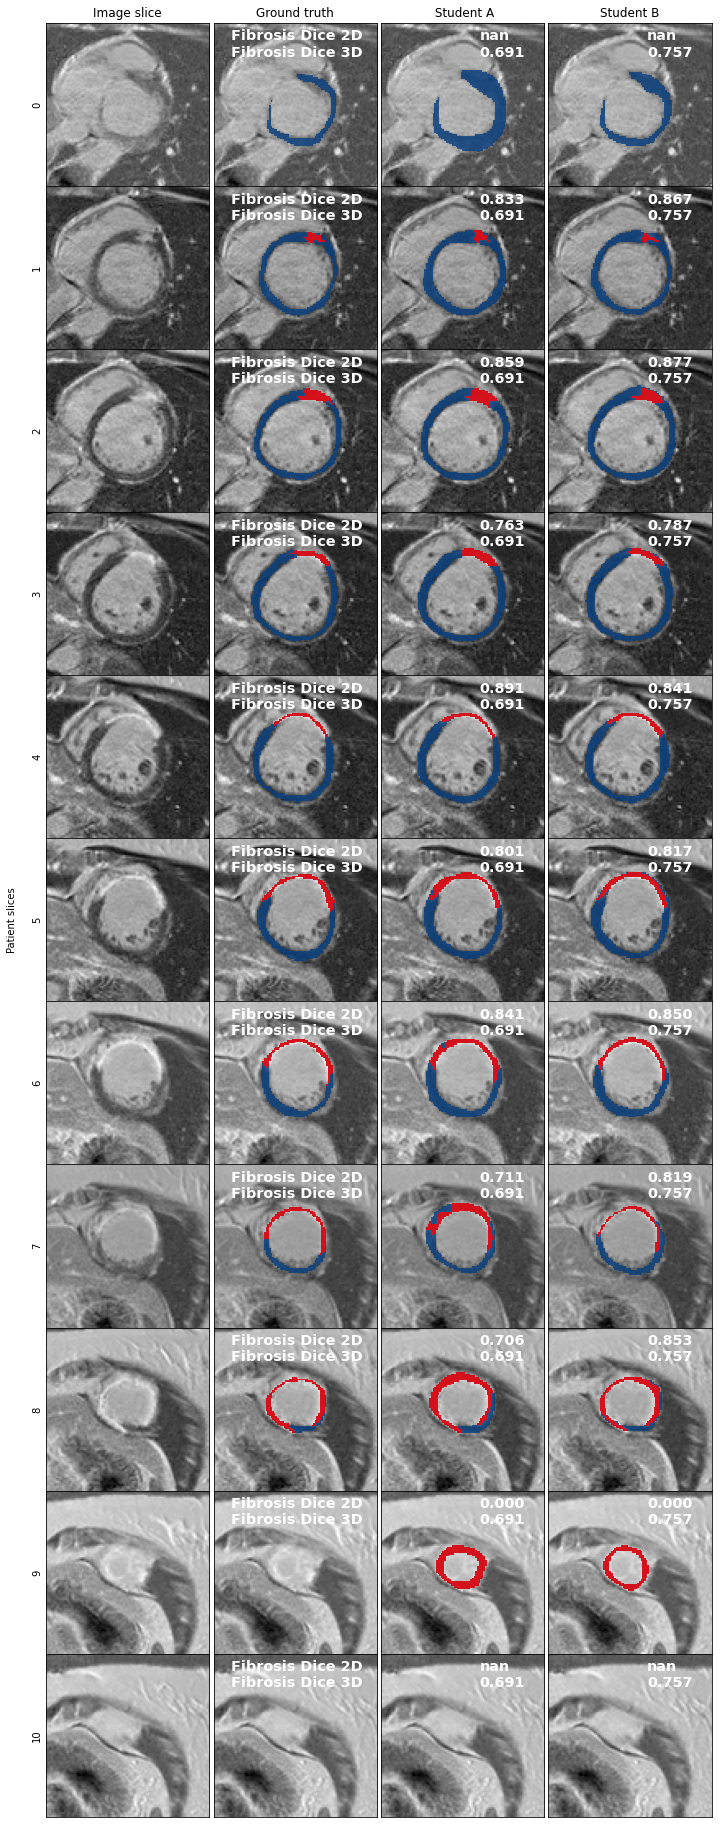

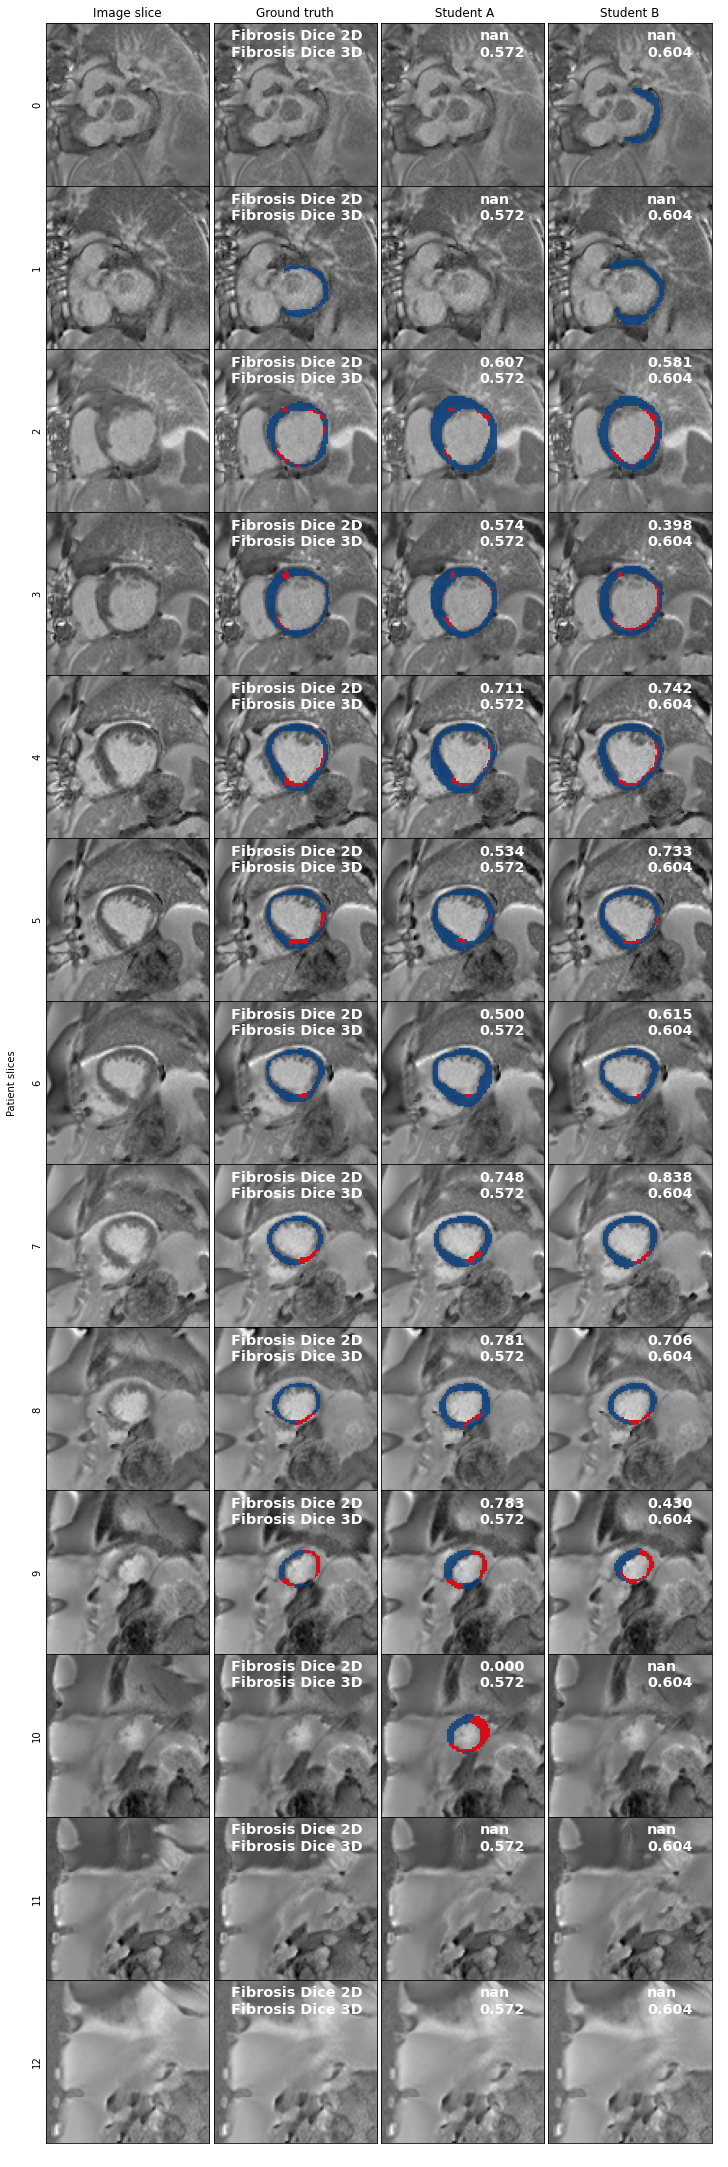

In [84]:
plot_data_v2(data, subplot_size=3)